In [1]:
import torch, torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from google.colab import drive, files
import matplotlib.pyplot as plt

MODEL

In [2]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Concatenate skip connection
        x = torch.cat((x, skip_input), 1)
        return x


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        # Encoder (Downsampling path)
        self.down1 = UNetDown(in_channels, 64, normalize=False)   # 256 → 128
        self.down2 = UNetDown(64, 128)                            # 128 → 64
        self.down3 = UNetDown(128, 256)                           # 64 → 32
        self.down4 = UNetDown(256, 512, dropout=0.5)              # 32 → 16
        self.down5 = UNetDown(512, 512, dropout=0.5)              # 16 → 8
        self.down6 = UNetDown(512, 512, dropout=0.5)              # 8 → 4
        self.down7 = UNetDown(512, 512, dropout=0.5)              # 4 → 2
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)  # 2 → 1

        # Decoder (Upsampling path)
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Downsampling path
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Upsampling path with skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

IMAGE PROCESSING

In [3]:
def preprocess_image(image_path, image_size=256):
    img = Image.open(image_path).convert("RGB")

    # Split the image in half before any augmentations
    w, h = img.size
    left_img = img.crop((0, 0, w//2, h))
    right_img = img.crop((w//2, 0, w, h))

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # scale to [-1, 1]
    ])

    left_tensor = transform(left_img).unsqueeze(0)  # add batch dimension: [1, 3, H, W]
    right_tensor = transform(right_img).unsqueeze(0)
    return left_tensor, right_tensor


def tensor_to_pil(tensor):
    # Remove batch dimension
    img_tensor = tensor.squeeze(0).detach().cpu()

    # Denormalize from [-1, 1] to [0, 1]
    img_tensor = (img_tensor * 0.5) + 0.5
    img_tensor = torch.clamp(img_tensor, 0.0, 1.0)

    to_pil = transforms.ToPILImage()
    return to_pil(img_tensor)

UTILITIES AND INFERENCE CODE

In [4]:
def load_generator(checkpoint_path, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNetGenerator()
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model, device

def run_inference(
    checkpoint_path: str,
    input_image_path: str,
    image_size: int = 256
):
    # Load model
    gen, device = load_generator(checkpoint_path)

    input_img, target_img = preprocess_image(input_image_path, image_size=image_size)
    input_img = input_img.to(device)
    target_img = target_img.to(device)

    with torch.no_grad():
        gen_img = gen(input_img)

    def denorm(tensor):
        tensor = (tensor + 1) / 2
        return torch.clamp(tensor, 0, 1)

    input_show = denorm(input_img.squeeze(0)).permute(1, 2, 0).cpu()
    gen_show = denorm(gen_img.squeeze(0)).permute(1, 2, 0).cpu()
    target_show = denorm(target_img.squeeze(0)).permute(1, 2, 0).cpu()

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    titles = ['Input', 'Generated', 'Target']
    images = [input_show, gen_show, target_show]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Facades Comparision

Saving 10.jpg to 10.jpg


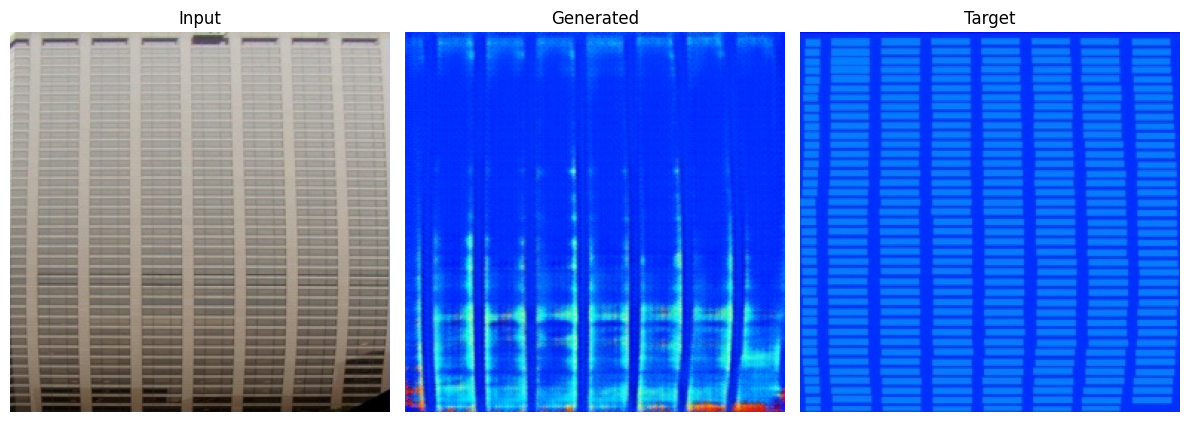

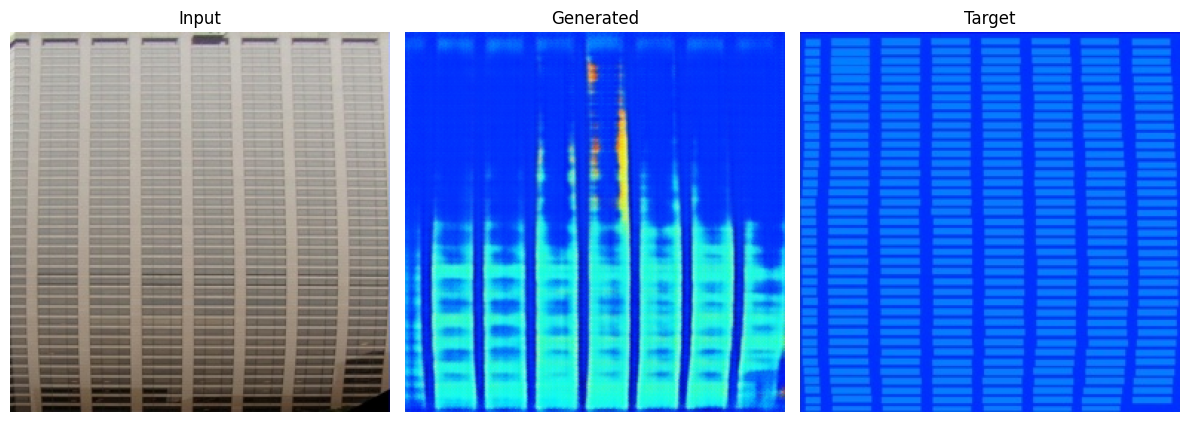

In [5]:
uploaded = files.upload()           # choose an image
img_path = next(iter(uploaded))

run_inference('/content/pix2pix_generator_facades_adv.pth', img_path)
run_inference('/content/pix2pix_generator_facades_vgg_perc_multi_patchgan.pth', img_path)

## CityScapes Comparision

Saving 15.jpg to 15.jpg


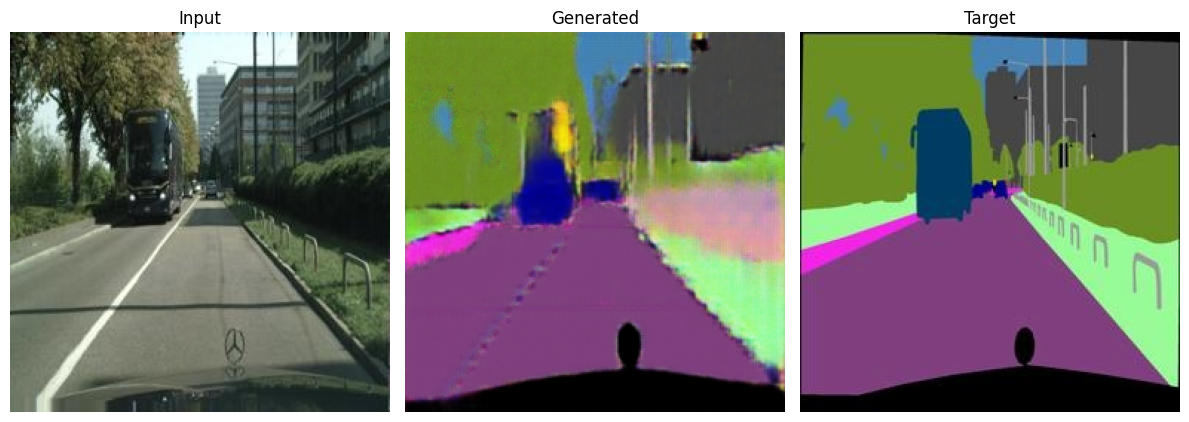

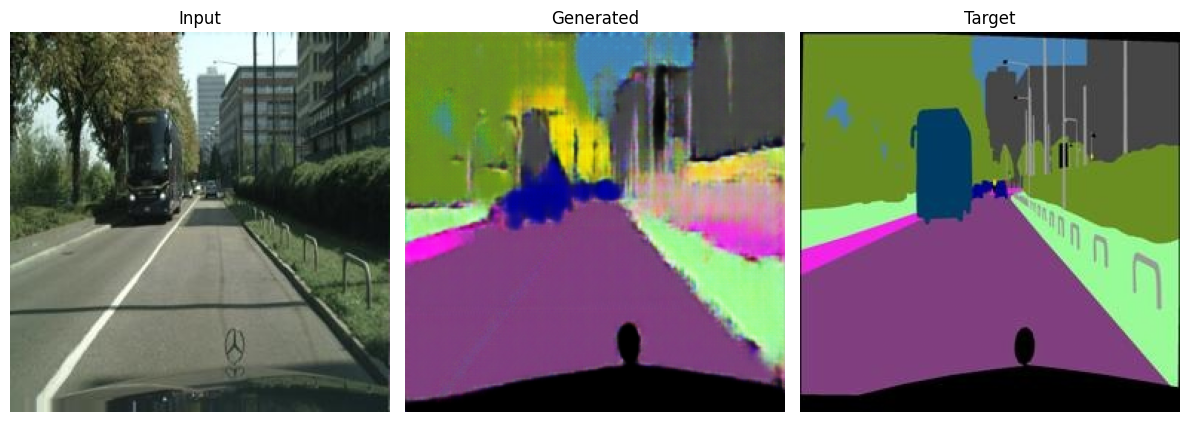

In [6]:
uploaded = files.upload()           # choose an image
img_path = next(iter(uploaded))

run_inference('/content/pix2pix_generator_cityscapes_adv.pth', img_path)
run_inference('/content/pix2pix_generator_cityscapes_vgg_perc_multi_patchgan.pth', img_path)

## Maps Comparision

Saving 1000.jpg to 1000.jpg


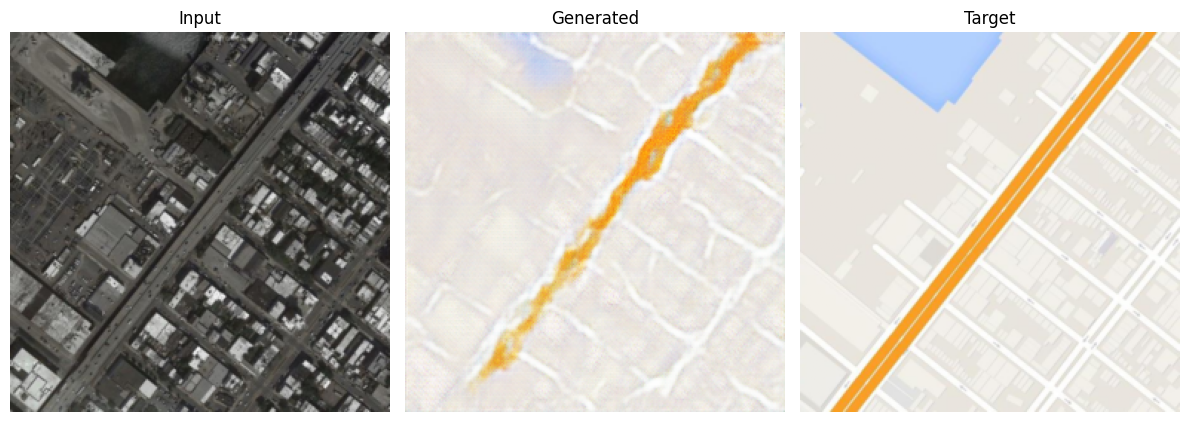

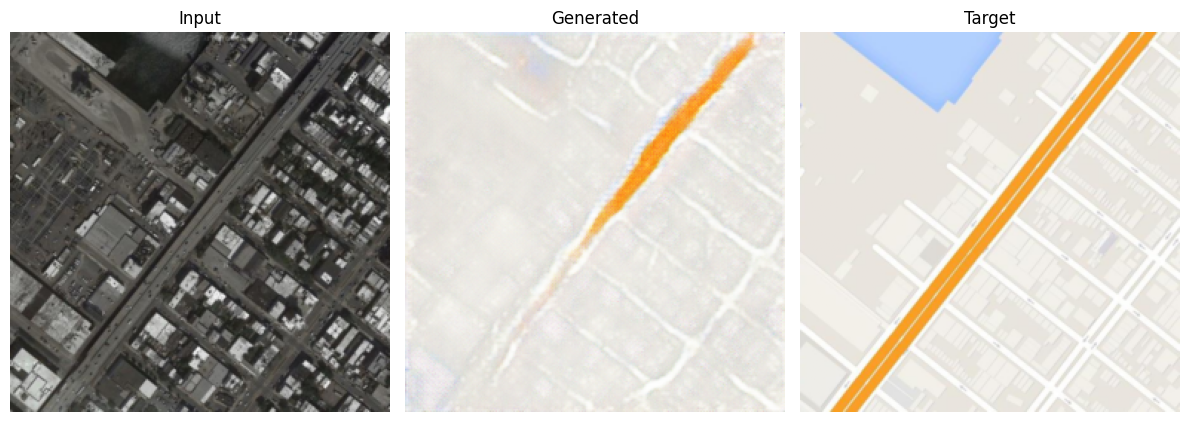

In [10]:
uploaded = files.upload()           # choose an image
img_path = next(iter(uploaded))

run_inference('/content/pix2pix_generator_maps_adv.pth', img_path)
run_inference('/content/pix2pix_generator_maps_vgg_perc_multi_patchgan.pth', img_path)